In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# for encoding the director and actors
from category_encoders import TargetEncoder

# to find the correlation on binary value of genres
from scipy.stats import pointbiserialr

# for modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [2]:
FILE= '../Datasets/IMDb Movies India.csv'

In [3]:
df = pd.read_csv(FILE, encoding='ISO-8859-1')

In [4]:
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


In [6]:
df.columns

Index(['Name', 'Year', 'Duration', 'Genre', 'Rating', 'Votes', 'Director', 'Actor 1', 'Actor 2', 'Actor 3'], dtype='object')

In [7]:
df.shape

(15509, 10)

In [8]:
df['Duration'].isna().sum()

np.int64(8269)

# DATA CLEANING

In [9]:
df.duplicated().sum()

np.int64(6)

In [10]:
df = df.drop_duplicates()

In [11]:
# Convert Year to an integer
def convertYear2Int(year):
    if pd.isna(year):
        return None
    return int(year.strip("()"))

df['Year'] = df['Year'].apply(convertYear2Int).astype('Int64')

In [12]:
# Convert Duration to an integer
def convertDuration2Int(duration) -> int:
    if pd.isna(duration):
        return None
    return int(duration.replace(' min', ''))

df['Duration'] = df['Duration'].apply(convertDuration2Int).astype('Int64')

In [13]:
# Convert Votes to an integer
def convertVote2Int(vote):
    try:
        if pd.isna(vote):
            return None
        return int(str(vote).replace(',', ''))
    except ValueError:
        return None
    except Exception as e:
        print(e)

df['Votes'] = df['Votes'].apply(convertVote2Int).astype('Int64')

In [14]:
# Handle Missing Values
print("No of missing values in Duration =", df['Duration'].isna().sum())
print("No of missing values in Director =", df['Director'].isna().sum())
print("No of missing values in Actor1 =", df['Actor 1'].isna().sum())
print("No of missing values in Actor2 =", df['Actor 2'].isna().sum())
print("No of missing values in Actor3 =", df['Actor 3'].isna().sum())

No of missing values in Duration = 8264
No of missing values in Director = 524
No of missing values in Actor1 = 1615
No of missing values in Actor2 = 2381
No of missing values in Actor3 = 3140


In [15]:
# fill unknown in case of missing Director and Actors
def fillUnknown(name):
    if pd.isna(name):
        return "Unknown"
    return name

df['Director'] = df['Director'].apply(fillUnknown).astype('str')
df['Actor 1'] = df['Actor 1'].apply(fillUnknown).astype('str')
df['Actor 2'] = df['Actor 2'].apply(fillUnknown).astype('str')
df['Actor 3'] = df['Actor 3'].apply(fillUnknown).astype('str')

## Handle Duration
- Since duration can contain ouliers, we cannot fill mean directly instead we will remove outlier using IQR(Inter Quartile Range) or standard deviation.
- Since most of the movies have same duration length we can also use mode. It makes more sense as most of the movies have nearly same duration.
- We can not use median as it does not make sence that we are using middle value of sorted array of Duration.

/tmp/ipykernel_100208/2558328456.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Duration'], kde=True)


<Axes: xlabel='Duration', ylabel='Density'>

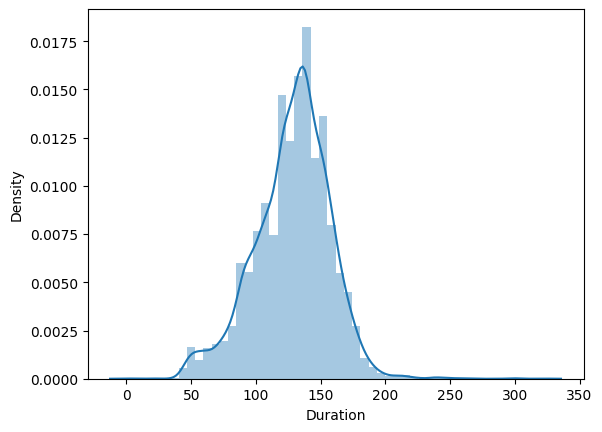

In [16]:
sns.distplot(df['Duration'], kde=True)

    above table shows that out dta is not highly skewed. We can apply IQR to remove outlier

In [17]:
df['Duration'].std()

np.float64(28.91447581777105)

In [18]:
df['Duration'].mean()

np.float64(128.1279182207487)

In [19]:
mode = df['Duration'].mode()[0]
print("Mode of Duration column =", mode)

Mode of Duration column = 120


    => Most of the movies are between (129 - 29) to (129 + 29)

<Axes: ylabel='Duration'>

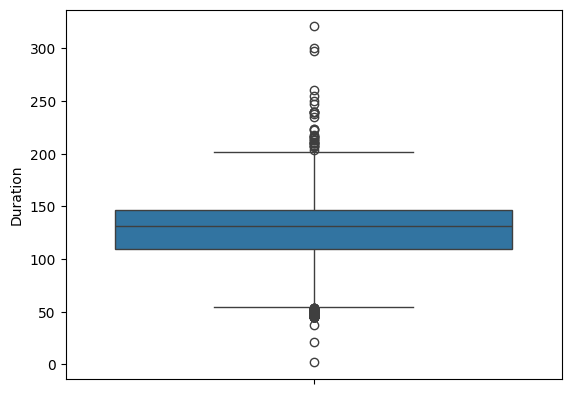

In [20]:
sns.boxplot(df['Duration'])

In [21]:
def find_mean():
    # Remove NaN values
    arr = df['Duration'].dropna().values  
    arr = np.sort(arr)

    # Compute Q1, Q3, and IQR
    Q1 = np.percentile(arr, 25)
    Q3 = np.percentile(arr, 75)
    IQR = Q3 - Q1

    # Compute lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # filter data
    filtered_arr = arr[(arr >= lower_bound) & (arr <= upper_bound)]

    return np.mean(filtered_arr)

mean_duration = find_mean()
print("Mean after removing outliers:", mean_duration)

Mean after removing outliers: 128.87933464899916


In [22]:
df['Duration'] = df['Duration'].fillna(np.round(mean_duration))

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15503 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15503 non-null  object 
 1   Year      14976 non-null  Int64  
 2   Duration  15503 non-null  Int64  
 3   Genre     13627 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7919 non-null   Int64  
 6   Director  15503 non-null  object 
 7   Actor 1   15503 non-null  object 
 8   Actor 2   15503 non-null  object 
 9   Actor 3   15503 non-null  object 
dtypes: Int64(3), float64(1), object(6)
memory usage: 1.3+ MB


In [24]:
df.describe()

,Year,Duration,Rating,Votes
count,14976.0,15503.0,7919.000000,7919.0
mean,1987.006677,128.592788,5.841621,1938.520394
std,25.417491,19.762234,1.381777,11602.415952
min,1913.0,2.0,1.100000,5.0
25%,1968.0,129.0,4.900000,16.0
50%,1991.0,129.0,6.000000,55.0
75%,2009.0,129.0,6.800000,404.0
max,2022.0,321.0,10.000000,591417.0


# FEATURE ENGINEERING

## One-Hot Encode Genre

In [25]:
genres = sorted(set(g.strip() for entry in df['Genre'].dropna() for g in entry.split(',')))

print(genres)
print(len(genres))

['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western']
24


In [26]:
for g in genres:
    df[f'genre_{g}'] = 0

df['Unknown'] = 0

In [27]:
for index, row in df.iterrows():
    data = row['Genre']
    if pd.isna(data):
        df.at[index, "Unknown"] = 1
    else:
        for g in str(data).split(','):
            df.at[index, f'genre_{g.strip()}'] = 1

In [28]:
df.tail()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,genre_Fantasy,genre_History,genre_Horror,genre_Music,genre_Musical,genre_Mystery,genre_News,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Thriller,genre_War,genre_Western,Unknown
15504,Zulm Ko Jala Doonga,1988,129,Action,4.6,11,Mahendra Shah,Naseeruddin Shah,Sumeet Saigal,Suparna Anand,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15505,Zulmi,1999,129,"Action, Drama",4.5,655,Kuku Kohli,Akshay Kumar,Twinkle Khanna,Aruna Irani,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15506,Zulmi Raj,2005,129,Action,NaN,<NA>,Kiran Thej,Sangeeta Tiwari,Unknown,Unknown,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15507,Zulmi Shikari,1988,129,Action,NaN,<NA>,Unknown,Unknown,Unknown,Unknown,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15508,Zulm-O-Sitam,1998,130,"Action, Drama",6.2,20,K.C. Bokadia,Dharmendra,Jaya Prada,Arjun Sarja,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
genre_counts = df.iloc[:, 10:34].sum().sort_values(ascending=True)
genre_counts

genre_Short             1
genre_Reality-TV        3
genre_Western           5
genre_News              9
genre_War              47
genre_Sci-Fi           58
genre_Sport            70
genre_Music            90
genre_Animation       125
genre_History         207
genre_Biography       208
genre_Documentary     383
genre_Fantasy         458
genre_Mystery         513
genre_Horror          524
genre_Adventure       541
genre_Musical         589
genre_Family          943
genre_Crime          1321
genre_Thriller       1711
genre_Comedy         2029
genre_Romance        2449
genre_Action         3542
genre_Drama          7242
dtype: int64

In [30]:
# Dropping least frequent column
genre_to_drop = genre_counts.index[0]
df.drop(columns=[genre_to_drop], inplace=True)
print(f"Dropped genre: {genre_to_drop}")

Dropped genre: genre_Short


## Extract Genre Popularity

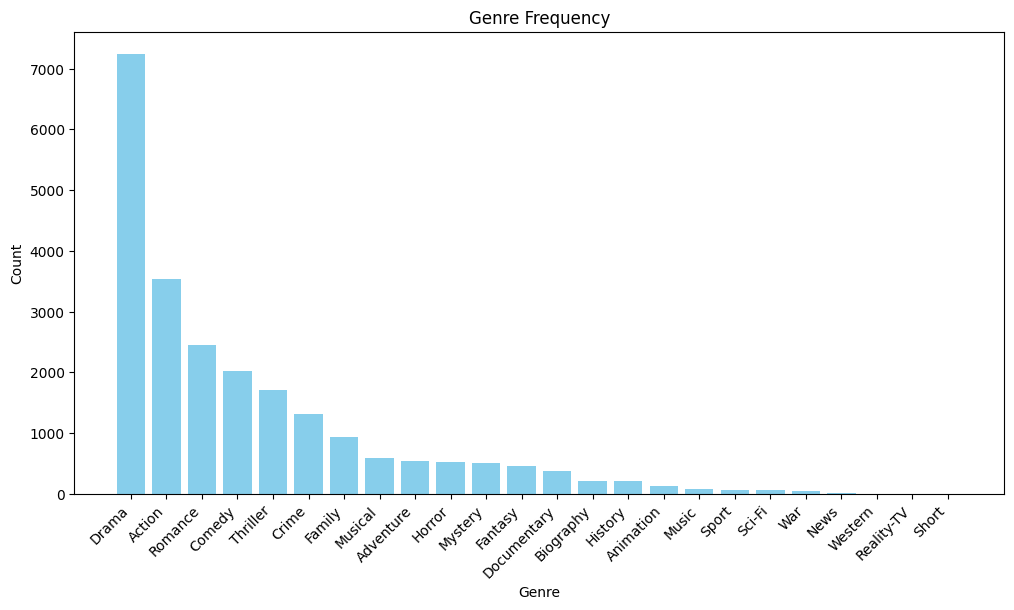

In [31]:
genre_list = [g.strip() for entry in df['Genre'].dropna() for g in entry.split(',')]

genre_counts = Counter(genre_list)

genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(genre_df['Genre'], genre_df['Count'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Genre Frequency')
plt.show()

    Conclusion above graph shows that mostly Drama are created in movies

In [32]:
# Drop rows where Genre is NaN
df_filtered = df.dropna(subset=['Genre'])

# Explode genre column to separate genres into different rows
df_exploded = df_filtered.assign(Genre=df_filtered['Genre'].str.split(',')).explode('Genre')

# Trim spaces
df_exploded['Genre'] = df_exploded['Genre'].str.strip()

/tmp/ipykernel_100208/2290840470.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_avg_rating.index, y=genre_avg_rating.values, palette="Blues_r")


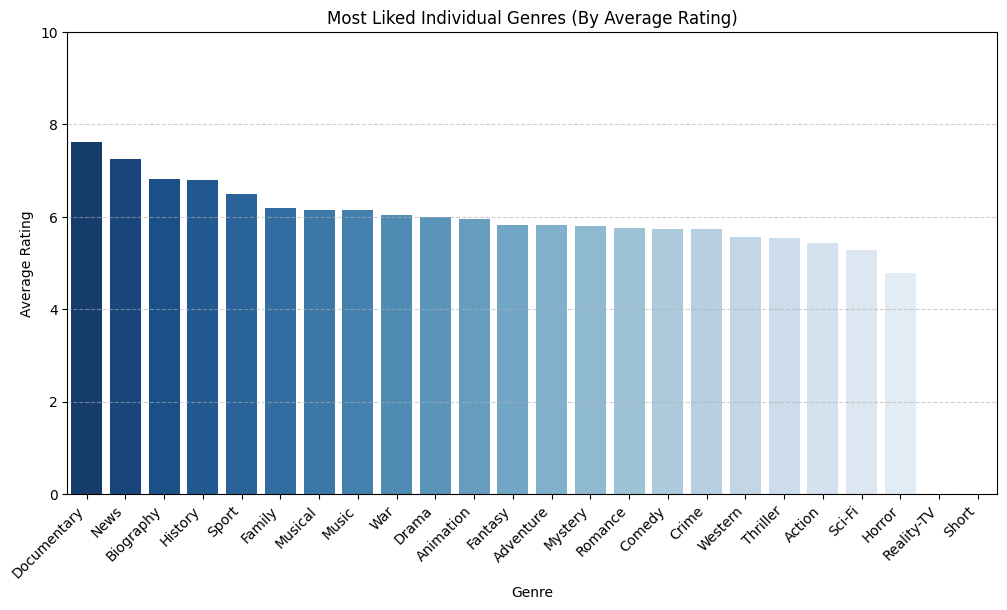

In [33]:
# average rating per individual genre
genre_avg_rating = df_exploded.groupby('Genre')['Rating'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_avg_rating.index, y=genre_avg_rating.values, palette="Blues_r")

plt.xticks(rotation=45, ha='right')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.title('Most Liked Individual Genres (By Average Rating)')
plt.ylim(0, 10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

/tmp/ipykernel_100208/736673153.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Genre'] = df_filtered['Genre'].str.replace(" ", "")
/tmp/ipykernel_100208/736673153.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_combination_avg_rating.index[:15], y=genre_combination_avg_rating.values[:15], palette="Oranges_r")


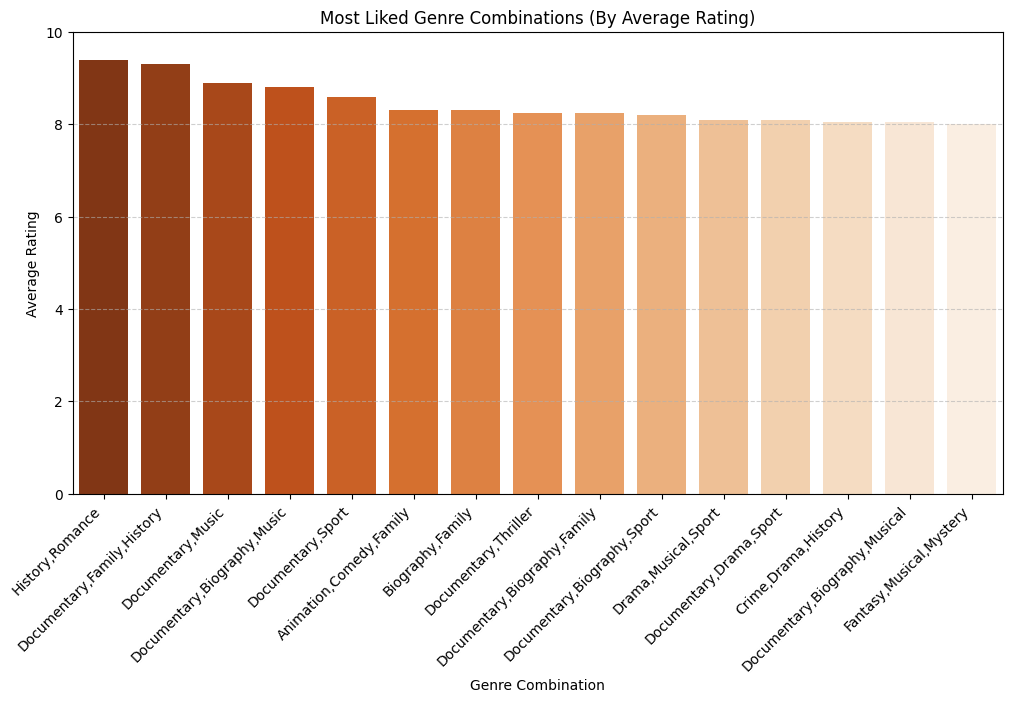

In [34]:
df_filtered['Genre'] = df_filtered['Genre'].str.replace(" ", "")

# average rating for full genre combinations
genre_combination_avg_rating = df_filtered.groupby('Genre')['Rating'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_combination_avg_rating.index[:15], y=genre_combination_avg_rating.values[:15], palette="Oranges_r")

plt.xticks(rotation=45, ha='right')
plt.xlabel('Genre Combination')
plt.ylabel('Average Rating')
plt.title('Most Liked Genre Combinations (By Average Rating)')
plt.ylim(0, 10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

    Conclusion: Above graphs shows that most people like documentary type of movies. Also combination of History and Romence are liked by most of the poeple.

## Extract Director Popularity

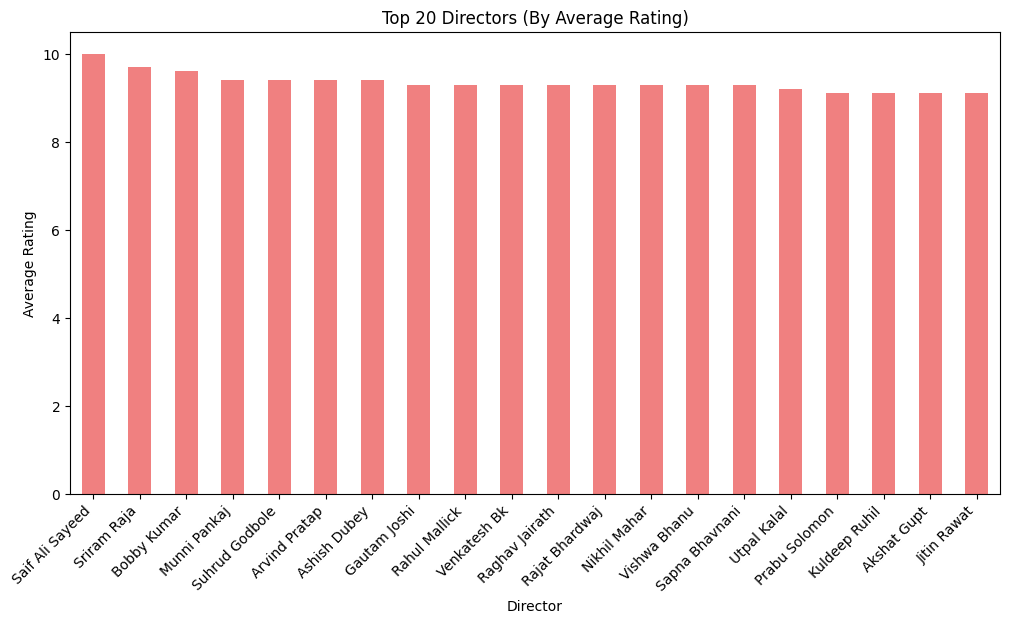

In [35]:
df_filtered = df[df['Director'] != "Unknown"]

# average rating per director
director_avg_rating = df_filtered.groupby('Director')['Rating'].mean().sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 6))
director_avg_rating.plot(kind='bar', color='lightcoral')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Director')
plt.ylabel('Average Rating')
plt.title('Top 20 Directors (By Average Rating)')
plt.show()

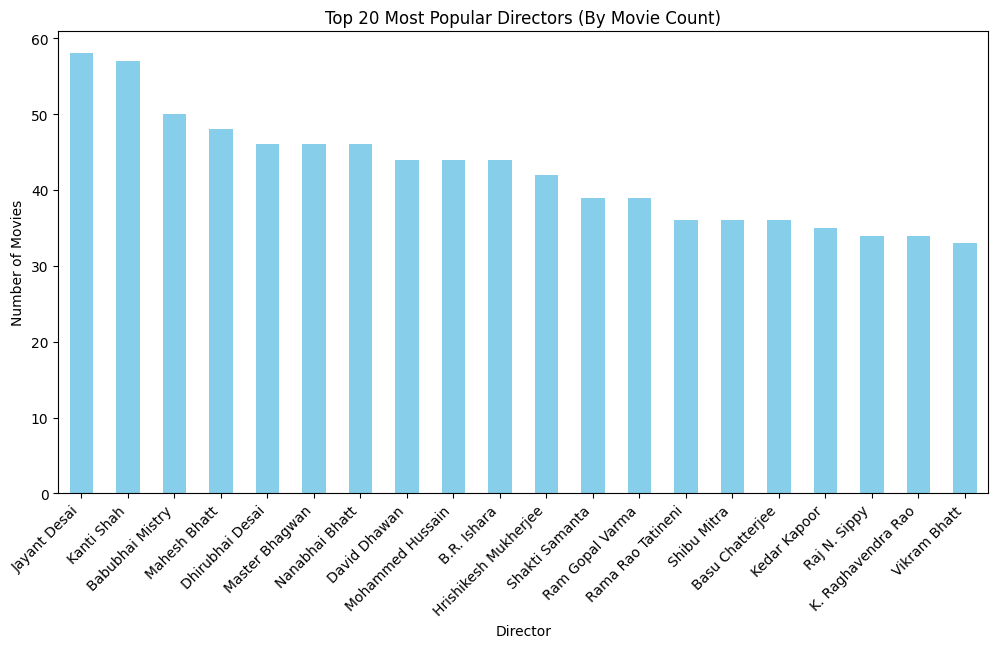

In [36]:

# Find top 20 directors with most movies
director_counts = df_filtered['Director'].value_counts().head(20)

plt.figure(figsize=(12, 6))
director_counts.plot(kind='bar', color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Director')
plt.ylabel('Number of Movies')
plt.title('Top 20 Most Popular Directors (By Movie Count)')
plt.show()

    Conclusion: Most of the movies are directed by Jayant Desai but most of the movies directed by Saif Ali Sayeed are like by most of the people.

## Extract Actor Popularity

/tmp/ipykernel_100208/517182082.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=actor_df['Actor'][:20], y=actor_df['Movie Count'][:20], palette="Purples_r")


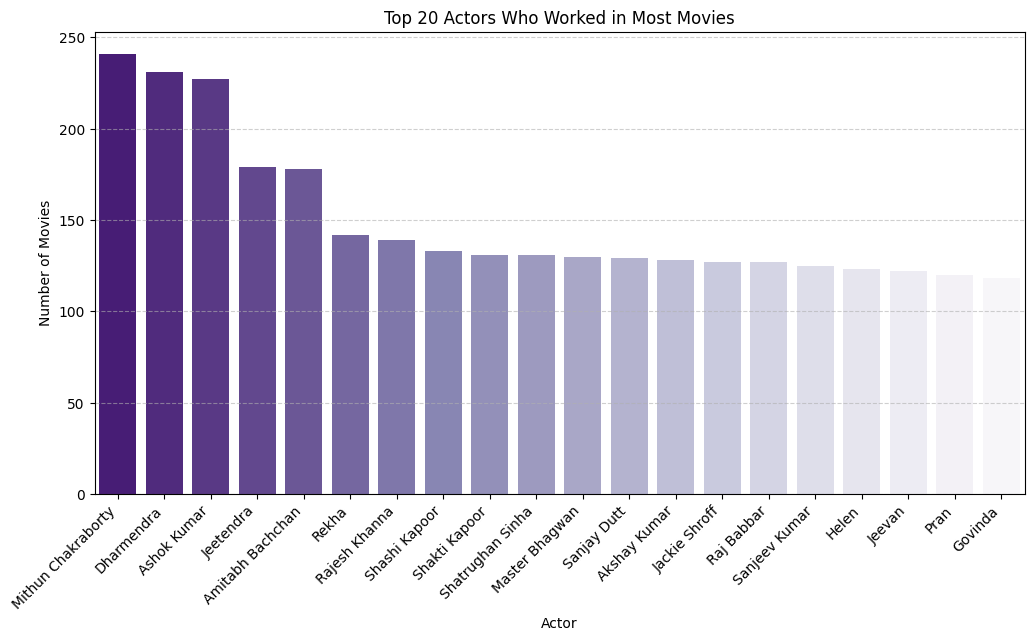

In [37]:
# Get all actors in a single list
actors_list = df[['Actor 1', 'Actor 2', 'Actor 3']].values.flatten()

actor_counts = Counter(actors_list)

if "Unknown" in actor_counts:
    del actor_counts["Unknown"]

actor_df = pd.DataFrame(actor_counts.items(), columns=['Actor', 'Movie Count']).sort_values(by='Movie Count', ascending=False)

# Plot Top 20 Actors by Movie Count
plt.figure(figsize=(12, 6))
sns.barplot(x=actor_df['Actor'][:20], y=actor_df['Movie Count'][:20], palette="Purples_r")

plt.xticks(rotation=45, ha='right')
plt.xlabel('Actor')
plt.ylabel('Number of Movies')
plt.title('Top 20 Actors Who Worked in Most Movies')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


/tmp/ipykernel_100208/1224813033.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=actor_rating_df['Actor'][:20], y=actor_rating_df['Average Rating'][:20], palette="Blues_r")


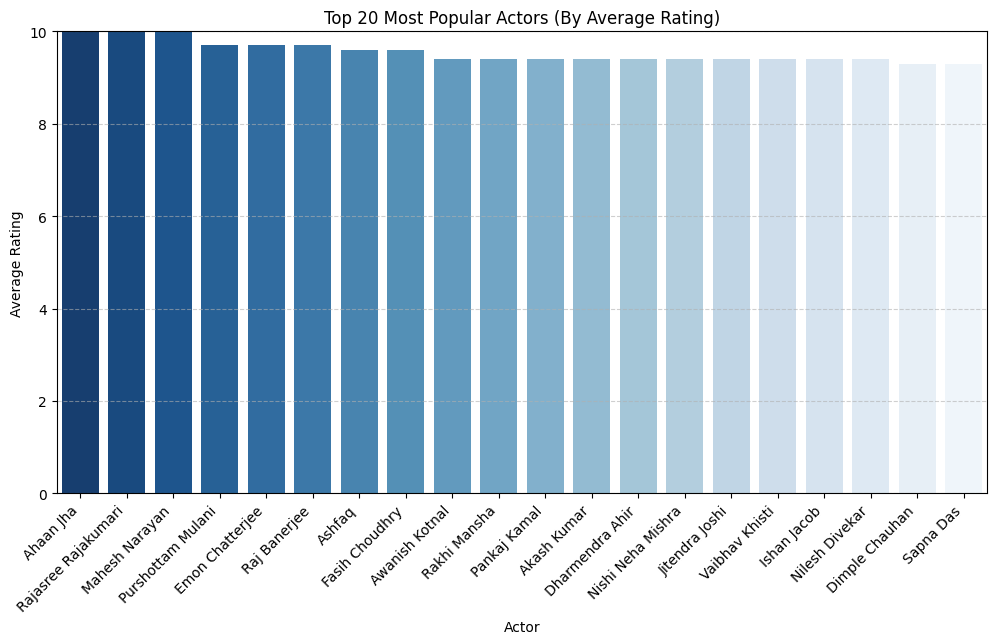

In [38]:
# Computing 20 Most Popular Actors
actor_ratings = {}

for _, row in df.iterrows():
    rating = row['Rating']
    if pd.isna(rating):
        continue
    for actor in ['Actor 1', 'Actor 2', 'Actor 3']:
        name = row[actor]
        if name != "Unknown" and not pd.isna(name):
            if name not in actor_ratings:
                actor_ratings[name] = []
            actor_ratings[name].append(rating)

actor_avg_rating = {actor: np.mean(ratings) for actor, ratings in actor_ratings.items()}

actor_rating_df = pd.DataFrame(actor_avg_rating.items(), columns=['Actor', 'Average Rating']).sort_values(by='Average Rating', ascending=False)

# Plot graph
plt.figure(figsize=(12, 6))
sns.barplot(x=actor_rating_df['Actor'][:20], y=actor_rating_df['Average Rating'][:20], palette="Blues_r")

plt.xticks(rotation=45, ha='right')
plt.xlabel('Actor')
plt.ylabel('Average Rating')
plt.title('Top 20 Most Popular Actors (By Average Rating)')
plt.ylim(0, 10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

/tmp/ipykernel_100208/1557136421.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[', '.join(p) for p in pair_rating_df['Pair'][:20]], y=pair_rating_df['Average Rating'][:20], palette="Greens_r")


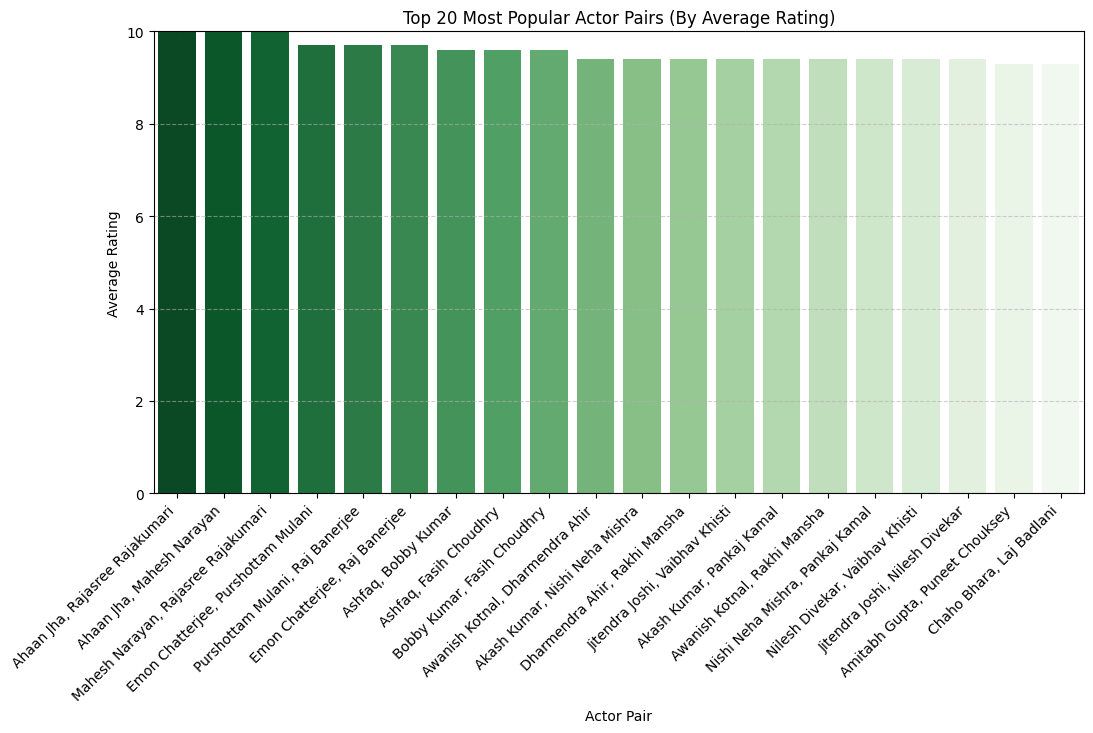

In [39]:
# computing popular actor pair
actor_pair_ratings = {}

for _, row in df.iterrows():
    rating = row['Rating']
    if pd.isna(rating):
        continue
    actors = [row['Actor 1'], row['Actor 2'], row['Actor 3']]
    actors = [a for a in actors if a != "Unknown" and not pd.isna(a)]

    # creating pairs
    for i in range(len(actors)):
        for j in range(i + 1, len(actors)):
            pair = tuple(sorted([actors[i], actors[j]]))
            if pair not in actor_pair_ratings:
                actor_pair_ratings[pair] = []
            actor_pair_ratings[pair].append(rating)

# Computing mean rating for each actor pair
actor_pair_avg_rating = {pair: np.mean(ratings) for pair, ratings in actor_pair_ratings.items()}

pair_rating_df = pd.DataFrame(actor_pair_avg_rating.items(), columns=['Pair', 'Average Rating']).sort_values(by='Average Rating', ascending=False)

# Plot the graph
plt.figure(figsize=(12, 6))
sns.barplot(x=[', '.join(p) for p in pair_rating_df['Pair'][:20]], y=pair_rating_df['Average Rating'][:20], palette="Greens_r")

plt.xticks(rotation=45, ha='right')
plt.xlabel('Actor Pair')
plt.ylabel('Average Rating')
plt.title('Top 20 Most Popular Actor Pairs (By Average Rating)')
plt.ylim(0, 10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

/tmp/ipykernel_100208/2396474461.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[', '.join(t) for t in trio_rating_df['Trio'][:20]], y=trio_rating_df['Average Rating'][:20], palette="Oranges_r")


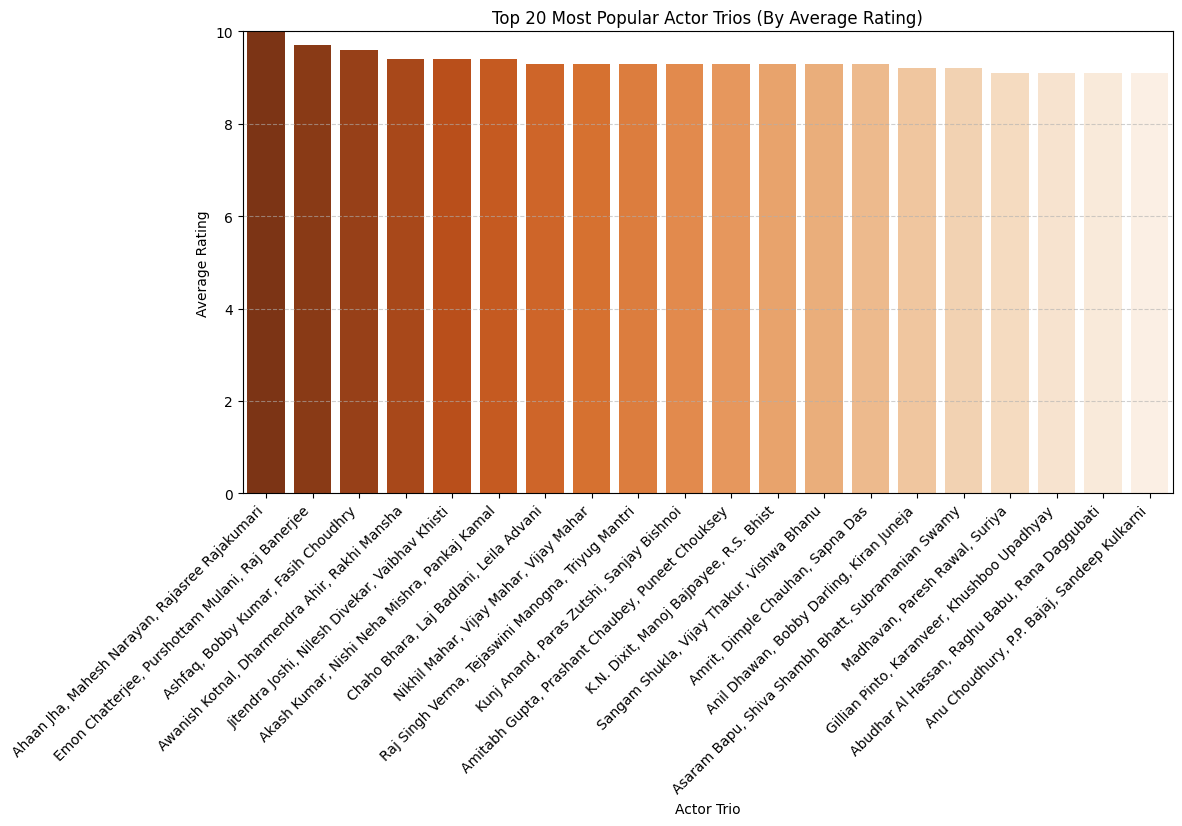

In [40]:
# computing popular actor trio
actor_trio_ratings = {}

for _, row in df.iterrows():
    rating = row['Rating']
    actors = (row['Actor 1'], row['Actor 2'], row['Actor 3'])

    # Skip if any actor is "Unknown" or NaN
    if any(pd.isna(a) or a == "Unknown" for a in actors):
        continue
    
    trio = tuple(sorted(actors))  # it maintain consistency
    if trio not in actor_trio_ratings:
        actor_trio_ratings[trio] = np.array([]) 
    actor_trio_ratings[trio] = np.append(actor_trio_ratings[trio], rating)

actor_trio_avg_rating = {trio: np.mean(ratings) for trio, ratings in actor_trio_ratings.items()}

trio_rating_df = pd.DataFrame(actor_trio_avg_rating.items(), columns=['Trio', 'Average Rating'])
trio_rating_df = trio_rating_df.sort_values(by='Average Rating', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=[', '.join(t) for t in trio_rating_df['Trio'][:20]], y=trio_rating_df['Average Rating'][:20], palette="Oranges_r")

plt.xticks(rotation=45, ha='right')
plt.xlabel('Actor Trio')
plt.ylabel('Average Rating')
plt.title('Top 20 Most Popular Actor Trios (By Average Rating)')
plt.ylim(0, 10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

    Conclusion: Mithum chakraborty has worked in most of the moives. 
    Ahaan jha, Rajasree Rajakumari and Mahesh Narayan - Movies with these actor are liked the most.
    Movies having Ahaan Jha and Rajasree Rajakumari both together are rated the most liked movies.
    Movies having tio of Ahaan Jha Mahesh Narayan and Rajasree Rajakumari are liked the most.

## Movie Age and their popularity

In [41]:
df['Movie_Age'] = 2025 - df['Year']

In [42]:
age_popularity = df.groupby('Movie_Age').agg({'Rating': 'mean', 'Votes': 'sum'}).reset_index()

age_popularity = age_popularity.sort_values(by='Movie_Age', ascending=True)

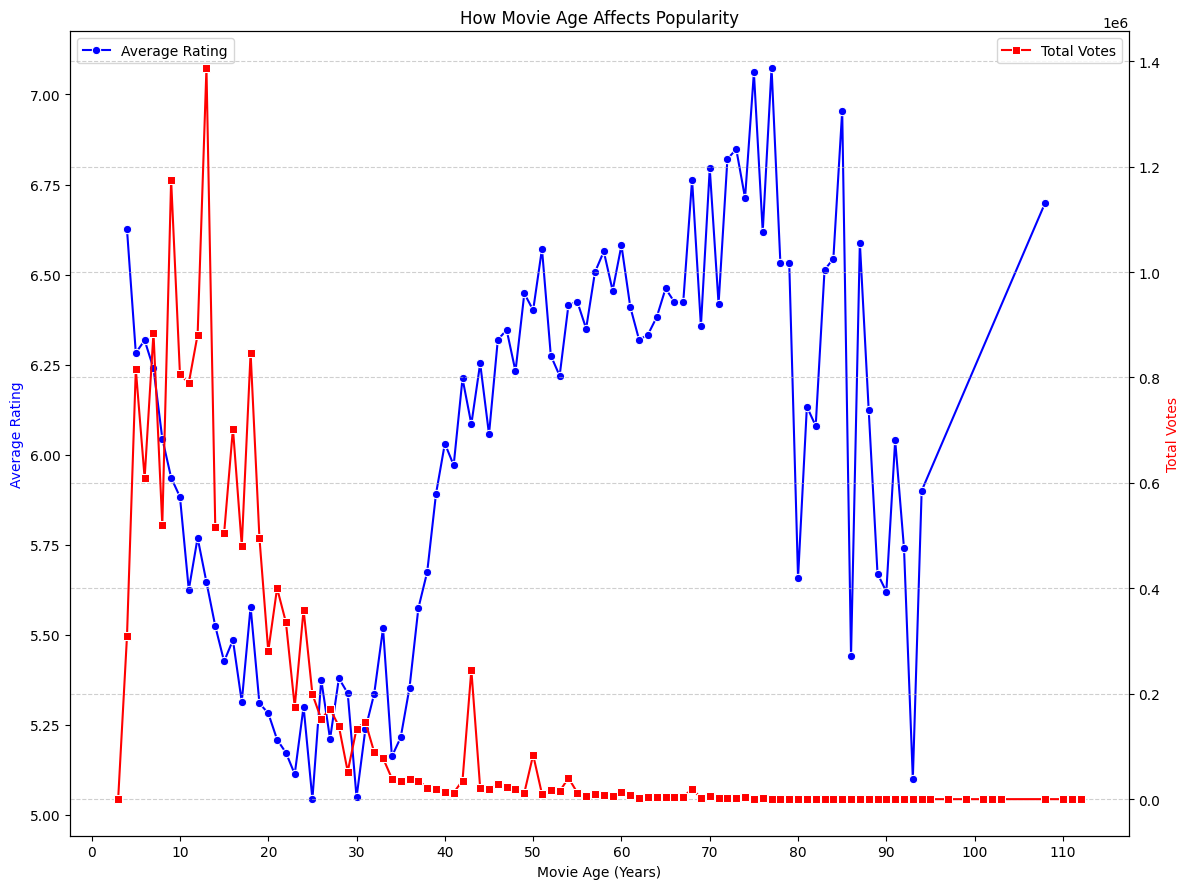

In [43]:
plt.figure(figsize=(12, 9))

# Plot Ratings Over Time
ax1 = plt.gca()
line1 = sns.lineplot(x=age_popularity['Movie_Age'], y=age_popularity['Rating'], marker='o', label='Average Rating', color='blue', ax=ax1)

# Plot Votes Over Time
ax2 = plt.twinx()
line2 = sns.lineplot(x=age_popularity['Movie_Age'], y=age_popularity['Votes'], marker='s', label='Total Votes', color='red', ax=ax2)

ax1.set_xlabel('Movie Age (Years)')
ax1.set_ylabel('Average Rating', color='blue')
ax2.set_ylabel('Total Votes', color='red')
plt.title('How Movie Age Affects Popularity')

plt.xticks(rotation=45)
plt.xticks(np.arange(0, max(df['Movie_Age'].dropna()) + 1, step=10))  # Show every 10 years
plt.grid(True, linestyle='--', alpha=0.6)

ax1.legend(loc='upper left', bbox_to_anchor=(0, 1))
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

    Conclusion: Around 6 to 20 years ago, we have recorded most vote count(i.e. we have found many people contribute by voting the movies) but popularity of the movies are decreasing or we can say after 30-40 years movies popularity is rising. Also 40 years ago, we got high rated movies but less vote count.

# PREPARING DATA FOR MODELING

In [44]:
Unseen_df = df[df['Rating'].isna()].reset_index(drop=True)
new_df = df[~df['Rating'].isna()].reset_index(drop=True) # unseen data by model as these does not contain rating

In [45]:
print("No of Unseen data =", len(Unseen_df))
print("No of data provided to the model for prediction =", len(new_df))

No of Unseen data = 7584
No of data provided to the model for prediction = 7919


### Encode Director and Actors

In [46]:
target_cols = ['Director', 'Actor 1', 'Actor 2', 'Actor 3']

encoder = TargetEncoder(cols=target_cols)

new_df[target_cols] = encoder.fit_transform(new_df[target_cols], new_df['Rating'])

### Find correlations

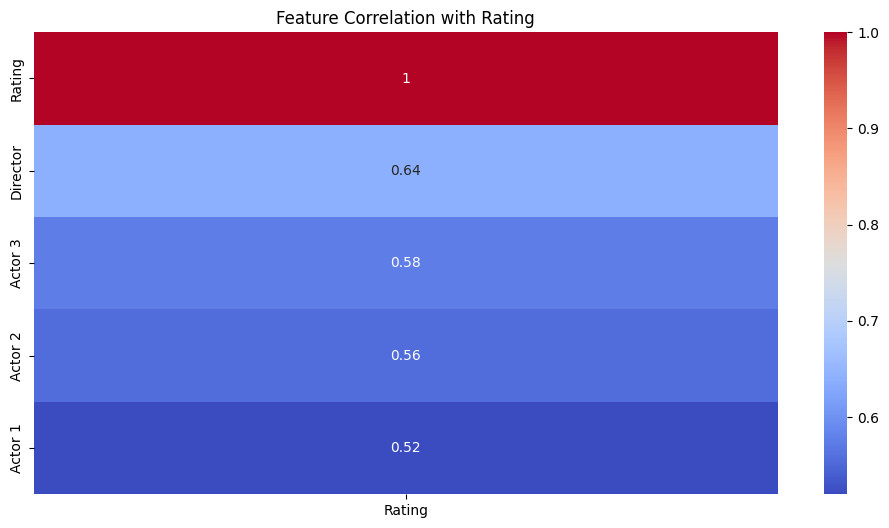

In [47]:
# Checking correlation of target features with Rating
correlation_matrix = new_df[target_cols + ['Rating']].corr()

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix[['Rating']].sort_values(by='Rating', ascending=False), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Rating")
plt.show()

In [48]:
print(new_df[['Duration', 'Rating']].corr())

          Duration    Rating
Duration  1.000000 -0.019878
Rating   -0.019878  1.000000


Weak correlation between Duration and Rating. We can drop Duration before modeling

In [49]:
new_df.drop(columns=['Duration'], inplace=True)

In [50]:
new_df.columns

Index(['Name', 'Year', 'Genre', 'Rating', 'Votes', 'Director', 'Actor 1', 'Actor 2', 'Actor 3', 'genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Biography', 'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_History', 'genre_Horror', 'genre_Music', 'genre_Musical', 'genre_Mystery', 'genre_News', 'genre_Reality-TV', 'genre_Romance', 'genre_Sci-Fi', 'genre_Sport', 'genre_Thriller', 'genre_War', 'genre_Western', 'Unknown', 'Movie_Age'], dtype='object')

In [51]:
genre_columns = [#'Name', 'Year', 'Duration', 'Genre', 'Rating', 'Votes', 'Director', 'Actor 1', 'Actor 2', 'Actor 3', 
                 'genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Biography',
                'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Family',
                'genre_Fantasy', 'genre_History', 'genre_Horror', 'genre_Music', 'genre_Musical',
                'genre_Mystery', 'genre_News', 'genre_Reality-TV', 'genre_Romance', 'genre_Sci-Fi', 
                'genre_Sport', 'genre_Thriller', 'genre_War', 'genre_Western', 'Unknown'
                #, 'Movie_Age'
                ]

In [52]:
# remove invalid columns ie. columns with single value in every row. This can be possible as we have splitted the data

valid_genre_columns = [genre for genre in genre_columns if new_df[genre].nunique() > 1]

genre_corr = {genre: pointbiserialr(new_df[genre], new_df['Rating'])[0] for genre in valid_genre_columns}
sorted_genre_corr = sorted(genre_corr.items(), key=lambda x: abs(x[1]), reverse=True)

print("Top genre correlations with Rating:", sorted_genre_corr[:5])

Top genre correlations with Rating: [('genre_Action', np.float64(-0.19381967225056776)), ('genre_Documentary', np.float64(0.17388454595258718)), ('genre_Horror', np.float64(-0.14640961024785887)), ('genre_Drama', np.float64(0.14563791256581055)), ('genre_Biography', np.float64(0.09565538338341664))]


# MODELING

### Split train and test data

In [53]:
from sklearn.model_selection import train_test_split

selected_features = ['Director', 'Actor 1', 'Actor 2', 'Actor 3'] + valid_genre_columns

# Split train_df into training and validation sets
X = new_df[selected_features]
y = new_df['Rating']

# Split Data into Train, Validation, and Test Sets (70-15-15)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [54]:
# Train Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [55]:
# Evaluate on Validation Set
y_val_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_val_pred)
rmse = mean_squared_error(y_val, y_val_pred) ** 0.5
r2 = r2_score(y_val, y_val_pred)

print(f"Validation MAE: {mae:.4f}")
print(f"Validation RMSE: {rmse:.4f}")
print(f"Validation R square Score: {r2:.4f}")

Validation MAE: 0.5428
Validation RMSE: 0.7873
Validation R² Score: 0.6814


In [56]:
# Final Model Evaluation on Test Set
y_test_pred = model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = mean_squared_error(y_test, y_test_pred) ** 0.5
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R square Score: {test_r2:.4f}")

Test MAE: 0.5148
Test RMSE: 0.7558
Test R² Score: 0.6931


In [57]:
# Apply Encoding and Predict on Unseen Data
Unseen_df[target_cols] = encoder.transform(Unseen_df[target_cols])

# Fill NaNs with global mean rating
global_mean_rating = y.mean()  # Compute global mean rating
Unseen_df[selected_features] = Unseen_df[selected_features].fillna(global_mean_rating)

# Predict Ratings for Unseen Data
y_unseen_pred = model.predict(Unseen_df[selected_features]) 

In [58]:
# Store Predictions
Unseen_df['Predicted_Rating'] = y_unseen_pred

In [59]:
Unseen_df.head(15)

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,genre_Fantasy,genre_History,genre_Horror,genre_Music,genre_Musical,genre_Mystery,genre_News,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Sport,genre_Thriller,genre_War,genre_Western,Unknown,Movie_Age,Predicted_Rating
0,,<NA>,129,Drama,NaN,<NA>,5.823195,5.841621,5.581091,5.841621,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,5.667
1,#Homecoming,2021,90,"Drama, Musical",NaN,<NA>,5.841621,5.992336,6.055587,5.841621,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,6.922
2,...And Once Again,2010,105,Drama,NaN,<NA>,5.938890,6.052939,5.820470,5.778977,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,6.473
3,.in for Motion,2008,59,Documentary,NaN,<NA>,5.841621,6.750375,6.623500,6.521233,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,5.830
4,101 Ratein,1990,129,Thriller,NaN,<NA>,5.719108,5.841621,5.841621,6.521233,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,35,5.762
5,108 Limited,<NA>,129,NaN,NaN,<NA>,5.841621,6.055587,5.886962,5.688323,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,<NA>,5.734
6,108 Teerthyatra,1987,129,"Comedy, Drama, Fantasy",NaN,<NA>,5.841621,5.841621,5.841621,5.841621,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,5.755
7,11 O'Clock,1948,129,NaN,NaN,<NA>,5.868696,5.841621,5.841621,5.841621,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,77,5.619
8,12 Bulbule,2021,129,"Comedy, Drama, Family",NaN,<NA>,6.013031,5.841621,5.841621,6.096423,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,6.884
9,12 Years,<NA>,129,Biography,NaN,<NA>,5.871234,6.750375,6.623500,6.521233,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,6.000
